In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def est_error(y_real, y_est, error, n_param):
    '''
    Takes in the observed data, our current step's estimated y-values 
    for the model, and our guess for the errors in the data.
    
    Returns sum-of-squares error assuming a 2-parameter model
    '''
    return ((y_real-y_est)**2/(n_param*error**2)).sum()/(y_real.size-n_param)


def est_model_vals(x_vals, p_1, p_2):
    '''
    Given x-values (log10 temperature) and our MCMC code's estimates for alpha and b, 
    this returns estimated y values (log10 bolometric luminosity) that we can compare 
    to the actul data.
    '''
    return p_2 + x_vals*p_1

def prior(alpha, b):
    '''
    Given values of alpha and b, return a probability based on prior knowledge that the user-supplied 
    values represent the real values.  Note that P(alpha,b) = P(alpha)*P(b), and the shape of the PDFs
    for each parameter are assumed to be Gaussian with a user-defined standard deviation, which are 
    shown below.
    
    NOTE: the assumed widths of these PDFs are broad, to reflect our uncertainty in the true value!
    '''
    alpha0 = 3.0
    sigma_alpha = 0.5
    b0 = -1.0
    sigma_b = 0.3
    
    p_alpha = (2.0*np.pi*sigma_alpha**2)**-0.5 * np.exp( -(alpha-alpha0)**2/(2.0*sigma_alpha**2))
        
    p_b = (2.0*np.pi*sigma_b**2)**-0.5 * np.exp( -(b-b0)**2/(2.0*sigma_b**2))
    
    return p_alpha*p_b


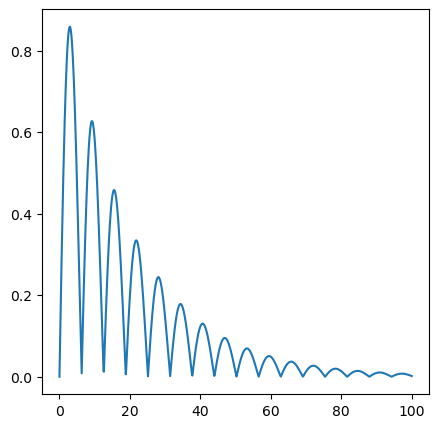

In [12]:
x_sim = np.linspace(0,100,1000)
y_sim = np.sin(x_sim/2)*np.exp(-x_sim/20)

fig, ax1 = plt.subplots()
fig.set_size_inches(5,5)

ax1.plot(x_sim, y_sim)

In [ ]:
import numpy.random as npr

# this is an ASSUMPTION FOR ACCEPT-1, since it doesn't have good x-ray data!
estimated_error = 0.2

# Initial guesses for alpha and b
alpha_old = 3
b_old = -1

# Range of step sizes that we take (assuming them to be the same for
# alpha and b, but doesn't have to be)
dalpha=db=0.01

# Total number of points we're going to sample (should be at least 10^4)
Npts = 100000
N_burn = 1000

# Initial model values and 'error' for our starting position
y_old = est_model_vals(alpha_old,b_old,logTemp)
err_old = est_error(logLbol,y_old,estimated_error)

# These lists keep track of our Markov Chain and errors so we can get our PDF later.
alpha_guess = []
b_guess = []
errors = []

iter_count = 0

# loop where we calculate our probabilities, etc.
for i in range(Npts):
    
    # Guess for our new point (A,B)
    alpha_new = alpha_old + npr.normal(0.0,dalpha)
    b_new = b_old + npr.normal(0.0,db)

    # model values based on the new A and B values
    ynew = est_model_vals(alpha_new,b_new,logTemp)
    
    # sum of squares value comparing data and model given our estimate
    # of the errors in the data.
    err_new = est_error(logLbol, ynew, estimated_error)
    
    
    '''
    ADD THE PROBABILITY OF ACCEPTANCE HERE!
    
    This should use the Bayesian probabilities, and thus include the likelihood function and the prior.
    
    HINT:  This would be a good opportunity to go back to the definition of Bayes' Theorem and think about
    how you would include the prior!
    '''
    p_old_b = np.exp(-err_new+err_old) * prior(alpha_old, b_old)
    p_new_b = np.exp(-err_new+err_old) * prior(alpha_new, b_new)
    
    p_accept = p_new_b/p_old_b  # YOU'RE GOING TO WANT TO CHANGE THIS.
    
    # if R < p_accept, we keep this point.  Otherwise, keep on moving!
    if npr.random() < p_accept:

        alpha_old = alpha_new
        b_old = b_new
        err_old = err_new
        
        if iter_count > N_burn:
            alpha_guess.append(alpha_old)
            b_guess.append(b_old)
            errors.append(err_old)

    iter_count += 1

print("acceptance ratio:",len(alpha_guess)/(Npts-N_burn))